## Cell 1: Imports and System Path Setup
This cell now includes the yaml library for parsing your config files.

In [171]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import yaml  # <-- Added for YAML loading

# --- IMPORTANT ---
# Add the root directory of your project to the system path
# This should be the '/home/seabra/multitask-enhancement/' directory
PROJECT_PATH = '/home/seabra/multitask-enhancement/'
sys.path.append(PROJECT_PATH)
sys.path.append(os.path.join(PROJECT_PATH, 'src'))

# Import your custom modules
try:
    from data.enhancer_train_datamodule import EnhancerTrainDataModule
    from models.multitask_module import EnhancerLitModule
    from models.components.MultiTaskDirMapEnh import MultiTaskDirMapEnh
    from models.components.UNet import UNet
    from models.components.ResUNet import ResUNet
except ImportError as e:
    print(f"Error importing modules: {e}")
    print(f"Please ensure PROJECT_PATH is set correctly. Current path: {PROJECT_PATH}")

# Helper function for visualization (unchanged)
def visualize_batch(batch, predictions=None, title="Data Batch Visualization"):
    """Helper function to visualize a sample from a batch."""
    # Unpack the batch
    lat, dirmap_target_idx, ref, bin_img, mask = batch
    
    # Select the first item in the batch for visualization
    lat = lat[0].cpu().squeeze()
    dirmap_target_idx = dirmap_target_idx[0].cpu().squeeze()
    ref = ref[0].cpu().squeeze()
    bin_img = bin_img[0].cpu().squeeze()
    mask = mask[0].cpu().squeeze()
    
    num_plots = 4
    if predictions:
        num_plots += 4 # Add plots for predictions

    fig, axs = plt.subplots(1, num_plots, figsize=(20, 4))
    fig.suptitle(title, fontsize=16)

    axs[0].imshow(lat, cmap='gray')
    axs[0].set_title('Input Latent')
    axs[0].axis('off')

    axs[1].imshow(dirmap_target_idx, cmap='jet', vmin=0, vmax=dirmap_target_idx.max())
    axs[1].set_title('GT Dirmap (Index)')
    axs[1].axis('off')

    axs[2].imshow(ref, cmap='gray')
    axs[2].set_title('GT Orig')
    axs[2].axis('off')
    
    axs[2].imshow(bin_img, cmap='gray')
    axs[2].set_title('GT Binarized')
    axs[2].axis('off')

    axs[3].imshow(mask, cmap='gray')
    axs[3].set_title('Mask')
    axs[3].axis('off')

    if predictions:
        pred_dirmap, pred_enh, gabor_map = predictions
        
        pred_dirmap_idx = torch.argmax(torch.sigmoid(pred_dirmap[0]), dim=0).cpu().detach()
        axs[4].imshow(pred_dirmap_idx, cmap='jet', vmin=0, vmax=89)
        axs[4].set_title('Pred Dirmap (Index)')
        axs[4].axis('off')

        pred_bin_img_probs = torch.sigmoid(pred_enh[0, 1, :, :]).cpu().detach()
        pred_bin_img = (pred_bin_img_probs > 0.5).float()
        axs[5].imshow(pred_bin_img, cmap='gray')
        axs[5].set_title('Pred Binarized')
        axs[5].axis('off')

        pred_orig_img_probs = pred_enh[0, 0, :, :].cpu().detach()
        pred_orig_img = (pred_orig_img_probs).float()
        axs[6].imshow(pred_orig_img, cmap='gray')
        axs[6].set_title('Pred Original')
        axs[6].axis('off')

        gabor_map_img = gabor_map[0, 0, :, :].cpu().detach()
        axs[7].imshow(gabor_map_img, cmap='gray')
        axs[7].set_title('Intermediate Gabor')
        axs[7].axis('off')

    plt.tight_layout()
    plt.show()

print("Imports and setup complete. ✅")
print(f"Project Path: {PROJECT_PATH}")

Imports and setup complete. ✅
Project Path: /home/seabra/multitask-enhancement/


## Cell 2: Configuration Loading from YAML
This is the new cell that loads your configurations from the specified YAML files. It also sets the DEVICE.

In [172]:
# --- Configuration File Paths ---
DATA_CONFIG_PATH = os.path.join(PROJECT_PATH, "configs/data/enhancer_train.yaml")
MODEL_CONFIG_PATH = os.path.join(PROJECT_PATH, "configs/model/enhancer.yaml")

# --- Helper function to load YAML ---
def load_config(config_path):
    """Loads a YAML config file."""
    if not os.path.exists(config_path):
        print(f"❌ Config file not found at: {config_path}")
        return None
    try:
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)
        return config
    except Exception as e:
        print(f"Error loading YAML from {config_path}: {e}")
        return None

# --- Load Configurations ---
print("Loading configurations...")
data_config = load_config(DATA_CONFIG_PATH)
model_config = load_config(MODEL_CONFIG_PATH)

# --- Set Device ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if data_config and model_config:
    print("Successfully loaded data and model configs. 🎉\n")
    print("--- Data Config Keys ---")
    print(data_config.keys())
    print("\n--- Model Config Keys ---")
    print(model_config.keys())
    print(f"\nUsing device: {DEVICE}")
else:
    print("\n❌ Failed to load one or more config files. Please check paths and file integrity.")

# --- Manual Overrides for Debugging ---
# We use a small batch size for easier debugging
if data_config:
    data_config['batch_size'] = 1
    data_config['num_workers'] = 4
    print(f"\nApplied debug overrides: batch_size={data_config['batch_size']}, num_workers={data_config['num_workers']}")

Loading configurations...
Successfully loaded data and model configs. 🎉

--- Data Config Keys ---
dict_keys(['_target_', 'data_dir', 'data_list', 'lat_subdir', 'ref_subdir', 'skel_subdir', 'bin_subdir', 'mask_subdir', 'ref_mask_subdir', 'occ_mask_subdir', 'mnt_subdir', 'orient_subdir', 'apply_mask', 'use_ref_mask', 'batch_size', 'train_val_split', 'num_workers', 'pin_memory'])

--- Model Config Keys ---
dict_keys(['_target_', 'optimizer_dirmap', 'optimizer_enh', 'scheduler_dirmap', 'scheduler_enh', 'net', 'compile', 'warmup_epochs_dirmap', 'output_path', 'use_patches'])

Using device: cuda

Applied debug overrides: batch_size=1, num_workers=4


## Cell 3: Load and Inspect the Data (from Config)
This cell now instantiates EnhancerTrainDataModule by unpacking the data_config dictionary. It also intelligently handles the data_dir path, assuming it's relative to your PROJECT_PATH.

Absolute data_dir set to: /storage/seabra/segmentation_study/train_data/

Successfully loaded one batch of data! 🎉

Input latent 'x' shape: 		torch.Size([1, 1, 512, 512]), type: torch.float32
Target dirmap 'target_dirmap_idx' shape: 	torch.Size([1, 1, 64, 64]), type: torch.int64
Target binary 'y_bin' shape: 		torch.Size([1, 1, 512, 512]), type: torch.float32
Mask 'mask' shape: 			torch.Size([1, 1, 512, 512]), type: torch.float32


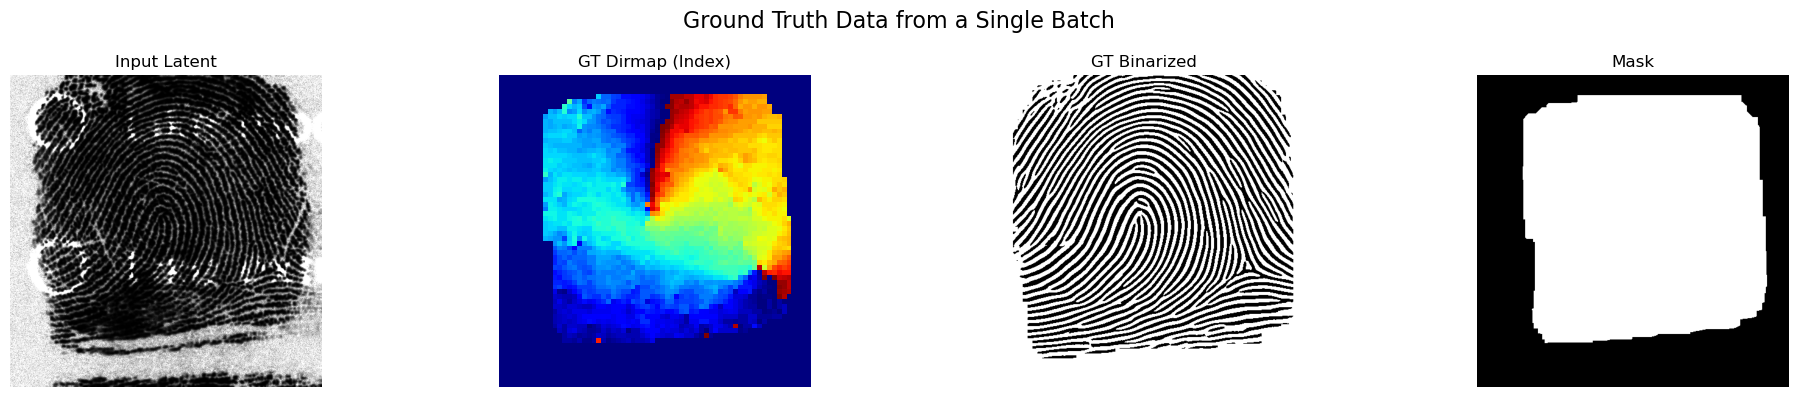

In [173]:
# 1. Instantiate the DataModule using the loaded config
try:
    # --- FIX 1: Remove the '_target_' key if it exists ---
    data_config.pop('_target_', None)

    # --- FIX 2: Resolve the data_dir path variable ---
    # The simple yaml loader doesn't resolve ${...} variables. We'll replace it manually.
    # We assume the base data directory is named 'data' inside your project path.
    # if 'data_dir' in data_config and '${paths.data_dir}' in data_config['data_dir']:
    #     print(f"Resolving data_dir variable from: {data_config['data_dir']}")
    #     # Replace the variable part with a default 'data' folder
    #     resolved_path = data_config['data_dir'].replace('${paths.data_dir}', "/storage/seabra/segmentation_study/train_data/")
    #     data_config['data_dir'] = os.path.join(PROJECT_PATH, resolved_path)
    # else:
    #     # Fallback for paths that don't use the variable
    #     data_config['data_dir'] = os.path.join(PROJECT_PATH, data_config.get('data_dir', "/storage/seabra/segmentation_study/train_data/"))

    data_config['data_dir'] = "/storage/seabra/segmentation_study/train_data/"
    print(f"Absolute data_dir set to: {data_config['data_dir']}")

    # Now, instantiate the data module
    data_module = EnhancerTrainDataModule(**data_config)
    
    # 2. Setup the datasets
    data_module.setup()

    # 3. Get the training dataloader
    train_dataloader = data_module.train_dataloader()

    # 4. Fetch one batch of data
    batch = next(iter(train_dataloader))
    print("\nSuccessfully loaded one batch of data! 🎉\n")
    
    # 5. Inspect the batch contents
    x, target_dirmap_idx, y_orig, y_bin, mask = batch
    print(f"Input latent 'x' shape: \t\t{x.shape}, type: {x.dtype}")
    print(f"Target dirmap 'target_dirmap_idx' shape: \t{target_dirmap_idx.shape}, type: {target_dirmap_idx.dtype}")
    # print(f"Target original 'y_orig' shape: \t{y_orig.shape}, type: {y_orig.dtype}")
    print(f"Target binary 'y_bin' shape: \t\t{y_bin.shape}, type: {y_bin.dtype}")
    print(f"Mask 'mask' shape: \t\t\t{mask.shape}, type: {mask.dtype}")
    
    # 6. Visualize the batch
    visualize_batch(batch, title="Ground Truth Data from a Single Batch")

except Exception as e:
    print(f"\n❌ Error setting up data: {e}")
    print("Please check your 'enhancer_train.yaml' config and file paths.")
    import traceback
    traceback.print_exc()

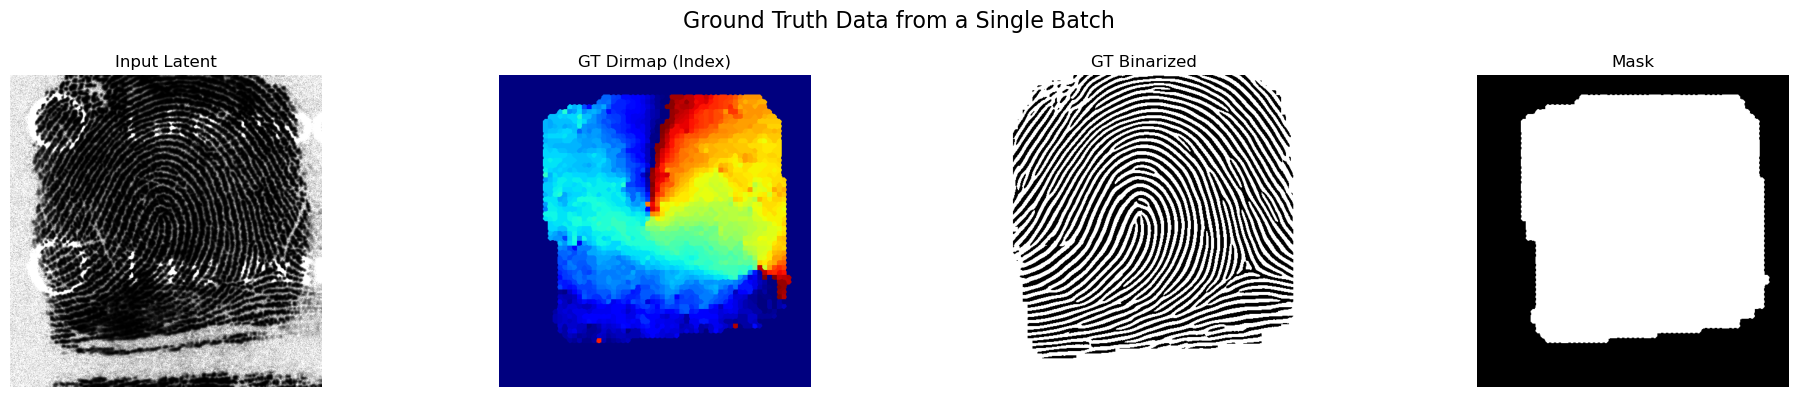

In [174]:
import torch.nn.functional as F

# Unpacks the batch tuple into its components.
# x: Input tensor (e.g., images), shape (B, C_in, H_small, W_small)
# true_dirmap_labels: Ground truth orientation labels at a small resolution
#                     Shape: (B, 1, H/8, W/8)
# y_orig, y_bin: Ground truth for enhancement (original and binary)
# roi_mask: Region of Interest mask, full resolution, Shape: (B, 1, H, W)
x, true_dirmap_labels, y_orig, y_bin, roi_mask = batch


# --- Prepare Targets ---
# Prepares (unpacks) the ground truth targets for loss calculation

# Extracts 'original' and 'binary' ground truth, removing channel dim
true_orig, true_bin = y_orig[:, 0, :, :], y_bin[:, 0, :, :]

# Downsamples the full-resolution ROI mask to match the initial label map size (1/8th scale)
# Output Shape: (B, 1, H/8, W/8)
small_dirmap_mask = F.interpolate(roi_mask, scale_factor=1/8, mode="bilinear") 

# --- Start of Complex Target Preparation ---
# The goal is to convert low-res angle labels (0-179) into full-res
# class indices (0-89) and a background mask.

# 'indices' holds the low-res angle labels. Shape: (B, 1, H/8, W/8)
indices = true_dirmap_labels 

# Finds all pixels with odd-numbered angles
is_odd = indices % 2 != 0
# Rounds odd angles down (e.g., 179 -> 178)
indices[is_odd] -= 1
# Maps angle ranges [0,1], [2,3]...[178,179] to classes 0, 1... 89
indices = indices // 2
# 'indices' now holds classes 0-89. Shape: (B, 1, H/8, W/8)

# Sets all pixels *outside* the downsampled ROI to class 90
# Class 90 will serve as the "ignore" or "background" class
indices[small_dirmap_mask == 0] = 90

# Initializes a zero tensor for one-hot encoding
# Shape: (B, 91, H/8, W/8) (90 classes + 1 'ignore' class)
one_hot = torch.zeros(indices.shape[0], 91, indices.shape[-2], indices.shape[-1], dtype=torch.float32, device=indices.device)

# Populates the 'one_hot' tensor. 
# For each pixel, it places a 1.0 at the channel index specified by 'indices'.
# 'indices' shape (B, 1, H/8, W/8) is broadcast-compatible for scatter.
one_hot.scatter_(dim=1, index=indices, value=1.0)

# 'orientation_one_hot' is the low-res one-hot map. Shape: (B, 91, H/8, W/8)
orientation_one_hot = one_hot

# Upsamples the one-hot target map by 8x (from H/8, W/8 to H, W)
# This matches the full resolution of the prediction 'pred_dirmap'
# Bilinear interpolation creates "soft" boundaries between classes.
# Output Shape: (B, 91, H, W)
true_dirmap = F.interpolate(orientation_one_hot, scale_factor=8, mode="bilinear", align_corners=False)

# Converts the "soft" upsampled map back to "hard" class indices
# by taking the argmax along the channel (class) dimension.
# Output Shape: (B, H, W)
true_dirmap_idx = true_dirmap.argmax(dim=1)

# Re-assigns 'true_dirmap_labels' to this new full-resolution index map
# Adds a channel dimension back.
# Output Shape: (B, 1, H, W). 
true_dirmap_labels = true_dirmap_idx.unsqueeze(1)

# Creates a binary mask. Pixels are 1 (keep) if they are NOT the
# 'ignore' class (90), and 0 (ignore) if they are.
# Output Shape: (B, 1, H, W). 
dirmap_mask = (true_dirmap_labels != 90).long()

# Sets the 'ignore' class pixels (90) to 0.
# This is safe because 'dirmap_mask' already knows to ignore them.
# This step makes the labels (0-89) compatible with the
# 90-class prediction 'pred_dirmap'.
true_dirmap_labels[true_dirmap_labels == 90] = 0

pre_processed_labels_batch = (x, true_dirmap_labels, y_orig, y_bin, dirmap_mask)

visualize_batch(pre_processed_labels_batch, title="Ground Truth Data from a Single Batch")

## Cell 4: Initialize Model and LightningModule (from Config)

In [175]:
# --- ❗️ CONFIGURATION: SET YOUR WEIGHTS FILE PATH HERE ---
# Set the full path to your pretrained model .pth or .ckpt file.
# If you don't want to load weights, set this to None.
PRETRAINED_WEIGHTS_PATH = "/home/seabra/multitask-enhancement/logs/train/runs/2025-11-03_20-17-29/checkpoints/epoch_015.ckpt"
# Example: PRETRAINED_WEIGHTS_PATH = "/home/seabra/multitask-enhancement/checkpoints/last.ckpt"

try:
    # --- Clean up top-level Hydra key ---
    model_config.pop('_target_', None)

    # --- 1. Instantiate the network from the 'net' config block ---
    print("Initializing model architecture...")
    if 'net' in model_config and isinstance(model_config['net'], dict):
        net_config = model_config['net'].copy()
        net_config.pop('_target_', None) 
        net_params = net_config
    else:
        net_params = {}

    net = MultiTaskDirMapEnh(**net_params).to(DEVICE)
    print(f"  -> Net: MultiTaskDirMapEnh with params: {net_params}")

    # --- 2. LOAD PRETRAINED WEIGHTS (NEW SECTION) ---
    if PRETRAINED_WEIGHTS_PATH and os.path.exists(PRETRAINED_WEIGHTS_PATH):
        print(f"\nAttempting to load weights from: {PRETRAINED_WEIGHTS_PATH}")
        try:
            # Load the checkpoint, mapping it to the correct device
            checkpoint = torch.load(PRETRAINED_WEIGHTS_PATH, map_location=DEVICE)
            
            # Check if the checkpoint is a dict and has 'state_dict' (standard for PyTorch Lightning)
            if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
                pretrained_state_dict = checkpoint['state_dict']
            else:
                # Assume the file is just the state_dict itself
                pretrained_state_dict = checkpoint

            # --- Handle key mismatches (very important!) ---
            # Often, weights saved from a LightningModule have a prefix like "net."
            # We need to remove this prefix to match the keys in our standalone `net` object.
            new_state_dict = {}
            for k, v in pretrained_state_dict.items():
                if k.startswith("net."):
                    new_state_dict[k.replace("net.", "", 1)] = v
                else:
                    # Keep keys that don't have the prefix (in case it was saved differently)
                    new_state_dict[k] = v
            
            # Load the state_dict. `strict=False` is safer as it ignores non-matching keys
            # (e.g., if you are not loading the enhancer part, or if the optimizer state is missing).
            missing_keys, unexpected_keys = net.load_state_dict(new_state_dict, strict=False)
            print("  -> Pretrained weights loaded successfully! ✅")
            if missing_keys:
                print(f"    - Note: Some keys were missing in the checkpoint: {missing_keys[:3]}...")
            if unexpected_keys:
                print(f"    - Note: Some keys in the checkpoint were not in the model: {unexpected_keys[:3]}...")

        except Exception as e:
            print(f"  -> ❌ Error loading weights: {e}")
    elif PRETRAINED_WEIGHTS_PATH:
        print(f"\n⚠️ Warning: Pretrained weights file not found at '{PRETRAINED_WEIGHTS_PATH}'. Skipping.")


    # --- 3. Define Optimizer Callables (Unchanged) ---
    print("\nParsing optimizer configs...")
    opt_dirmap_cfg = model_config['optimizer_dirmap'].copy()
    opt_enh_cfg = model_config['optimizer_enh'].copy()
    for cfg in [opt_dirmap_cfg, opt_enh_cfg]:
        cfg.pop('_target_', None); cfg.pop('_partial_', None)
    optimizer_dirmap_callable = partial(torch.optim.AdamW, **opt_dirmap_cfg)
    optimizer_enh_callable = partial(torch.optim.AdamW, **opt_enh_cfg)
    print(f"  -> Dirmap Optimizer: AdamW with params: {opt_dirmap_cfg}")
    print(f"  -> Enhancer Optimizer: AdamW with params: {opt_enh_cfg}")

    # --- 4. Define Scheduler Callables (Unchanged) ---
    print("Parsing scheduler configs...")
    sched_dirmap_cfg = model_config['scheduler_dirmap'].copy()
    sched_enh_cfg = model_config['scheduler_enh'].copy()
    for cfg in [sched_dirmap_cfg, sched_enh_cfg]:
        cfg.pop('_target_', None); cfg.pop('_partial_', None)
    scheduler_dirmap_callable = partial(torch.optim.lr_scheduler.ReduceLROnPlateau, **sched_dirmap_cfg)
    scheduler_enh_callable = partial(torch.optim.lr_scheduler.ReduceLROnPlateau, **sched_enh_cfg)
    print(f"  -> Dirmap Scheduler: ReduceLROnPlateau with params: {sched_dirmap_cfg}")
    print(f"  -> Enhancer Scheduler: ReduceLROnPlateau with params: {sched_enh_cfg}")

    # --- 5. Get other HPs for the LitModule (Unchanged) ---
    keys_to_exclude = [
        'optimizer_dirmap', 'optimizer_enh', 'scheduler_dirmap', 'scheduler_enh', 'net', 'compile'
    ]
    lit_module_hps = {k: v for k, v in model_config.items() if k not in keys_to_exclude}
    print(f"\nPassing other HPs to LitModule: {list(lit_module_hps.keys())}")

    # --- 6. Instantiate the LightningModule (Unchanged) ---
    lit_model = EnhancerLitModule(
        net=net, # Pass the network with the newly loaded weights
        optimizer_dirmap=optimizer_dirmap_callable,
        optimizer_enh=optimizer_enh_callable,
        scheduler_dirmap=scheduler_dirmap_callable,
        scheduler_enh=scheduler_enh_callable,
        compile=False,
        **lit_module_hps
    ).to(DEVICE)

    print("\nModel and LightningModule initialized successfully. 🚀")

except Exception as e:
    print(f"\n❌ Error initializing model from config: {e}")
    print("Please check your 'enhancer.yaml' config.")
    import traceback
    traceback.print_exc()

Initializing model architecture...
  -> Net: MultiTaskDirMapEnh with params: {'ndim': 2}

Attempting to load weights from: /home/seabra/multitask-enhancement/logs/train/runs/2025-11-03_20-17-29/checkpoints/epoch_015.ckpt


/tmp/ipykernel_507737/1358140835.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(PRETRAINED_WEIGHTS_PATH, map_location=DEVICE)


  -> Pretrained weights loaded successfully! ✅
    - Note: Some keys in the checkpoint were not in the model: ['coherence_loss_fn.cos_terms', 'coherence_loss_fn.sin_terms', 'coherence_loss_fn.j3_kernel']...

Parsing optimizer configs...
  -> Dirmap Optimizer: AdamW with params: {'lr': '1e-4', 'weight_decay': 0.0}
  -> Enhancer Optimizer: AdamW with params: {'lr': '5e-4', 'weight_decay': 0.0}
Parsing scheduler configs...
  -> Dirmap Scheduler: ReduceLROnPlateau with params: {'mode': 'min', 'factor': 0.1, 'patience': 5}
  -> Enhancer Scheduler: ReduceLROnPlateau with params: {'mode': 'min', 'factor': 0.2, 'patience': 8}

Passing other HPs to LitModule: ['warmup_epochs_dirmap', 'output_path', 'use_patches']

Model and LightningModule initialized successfully. 🚀


## Cell 5: Manual Forward Pass (model_step)

In [176]:
# First, ensure the 'batch' variable exists from running the cell above
if 'batch' not in locals():
    print("❌ 'batch' is not defined. Please re-run Cell 3 to load the data first.")
else:
    # Move the batch to the same device as the model
    x, target_dirmap_idx, y_bin, y_orig, mask = [t.to(DEVICE) for t in batch]
    device_batch = (x, target_dirmap_idx, y_bin, y_orig, mask)

    # --- Perform a single forward pass and calculate losses ---
    print("Running a single `model_step` (Forward Pass + Loss Calculation)...")

    print(target_dirmap_idx.shape, mask.shape)

    try:
        # Get the dictionary of losses
        losses = lit_model.model_step(device_batch)
        
        # Inspect the calculated losses
        ori_loss = losses["ori_loss"]
        enh_loss = losses["enh_loss"]
        total_loss = losses["total_loss"]

        print("\n--- Calculated Losses ---")
        print(f"Orientation Loss: \t{ori_loss.item():.4f}")
        print(f"Enhancement Loss: \t{enh_loss.item():.4f}")
        print(f"Total Loss: \t\t{total_loss.item():.4f}")
        
        # Also, let's get the model's output for visualization
        with torch.no_grad():
            pred_dirmap, pred_enh, intermediate_gabor = lit_model.forward(x)
            predictions = (pred_dirmap, pred_enh, intermediate_gabor)
            visualize_batch(device_batch, predictions, "Model Predictions vs. Ground Truth")

    except Exception as e:
        print(f"❌ Error during model_step: {e}")
        import traceback
        traceback.print_exc()

Running a single `model_step` (Forward Pass + Loss Calculation)...
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 512, 512])
❌ Error during model_step: CUDA out of memory. Tried to allocate 90.00 MiB. GPU 0 has a total capacity of 23.57 GiB of which 69.94 MiB is free. Process 506987 has 16.70 GiB memory in use. Including non-PyTorch memory, this process has 6.78 GiB memory in use. Of the allocated memory 6.27 GiB is allocated by PyTorch, and 219.40 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Traceback (most recent call last):
  File "/tmp/ipykernel_507737/966124471.py", line 16, in <module>
    losses = lit_model.model_step(device_batch)
  File "/home/seabra/multitask-enhancement/src/models/multitask_module.py", line 295, in model_step
    loss_ori_weighted = self.orientation_loss_fn(pred_dirmap, true_dirmap_labels, dirmap_mask)
  File "/storage/seabra/miniconda3/envs/hydra/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/storage/seabra/miniconda3/envs/hydra/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/seabra/multitask-enhancement/src/models/multitask_module.py", line 42, in forward
    log_one_minus_p = F.logsigmoid(-logits)
torch.OutOfMemoryError: CUDA out of memory. Tried to allocate 90.00 MiB. GPU 0 has a total capacity of 23.57 GiB of which 69.94 MiB is free. Process 506987 has 16.70

In [177]:
# import torch.nn.functional as F

# def gaussian_kernel1d(sigma: float, truncate: float = 3.0, device=None):
#     """Creates a 1D Gaussian kernel normalized to sum to 1."""
#     radius = int(truncate * sigma + 0.5)
#     x = torch.arange(-radius, radius + 1, device=device, dtype=torch.float32)
#     kernel = torch.exp(-0.5 * (x / sigma) ** 2)
#     kernel /= kernel.sum()
#     return kernel


# def gaussian_blur2d(x: torch.Tensor, sigma: float):
#     """Applies Gaussian blur to a 4D tensor (B, C, H, W) using separable convs."""
#     B, C, H, W = x.shape
#     device = x.device

#     # Create 1D kernels
#     kernel_1d = gaussian_kernel1d(sigma, device=device)
#     k = kernel_1d.view(1, 1, -1, 1)  # vertical
#     k_t = kernel_1d.view(1, 1, 1, -1)  # horizontal

#     # Apply separable convs (per channel)
#     x = F.conv2d(x, k.expand(C, 1, -1, 1), groups=C, padding=(kernel_1d.numel() // 2, 0))
#     x = F.conv2d(x, k_t.expand(C, 1, 1, -1), groups=C, padding=(0, kernel_1d.numel() // 2))
#     return x

# def gaussian_soft_label(target, sigma=2.0, scale_factor=8, num_classes=8):
#     """
#     Converts block-level labels (B, 1, H//8, W//8) into a smooth Gaussian probability map (B, C, H, W).
#     """
#     B, _, h, w = target.shape
#     device = target.device

#     # One-hot encode coarse labels
#     target_onehot = F.one_hot(target.squeeze(1).long(), num_classes=num_classes).permute(0, 3, 1, 2).float()

#     # Upsample with nearest to the final size first
#     coarse = F.interpolate(target_onehot, scale_factor=scale_factor, mode='nearest')

#     # Apply Gaussian smoothing per class channel
#     kernel_size = int(6*sigma + 1)
#     padding = kernel_size // 2
#     smoothed = gaussian_blur2d(coarse, sigma=sigma)

#     # Normalize so each pixel’s probabilities sum to 1
#     smoothed = smoothed / (smoothed.sum(dim=1, keepdim=True) + 1e-8)
#     return smoothed

# # One-hot encode and upsample with bilinear interpolation
# gt_onehot = F.one_hot(target_dirmap_idx.squeeze(1).long(), num_classes=90).permute(0, 3, 1, 2).float()
# gt_soft = F.interpolate(gt_onehot, scale_factor=8, mode='bilinear', align_corners=False)

# gt_hard = F.interpolate(gt_onehot, scale_factor=8, mode='nearest')

# # Normalize soft labels
# gt_soft = gt_soft / (gt_soft.sum(dim=1, keepdim=True) + 1e-8)


# plt.imshow(gt_hard[0, 44, :, :].cpu().detach(), cmap='gray')             # imagem de base
# plt.imshow(gt_soft[0, 44, :, :].cpu().detach(), cmap='jet', alpha=0.5)   # sobreposição sem apagar o fundo
# plt.axis('off')
# plt.show()


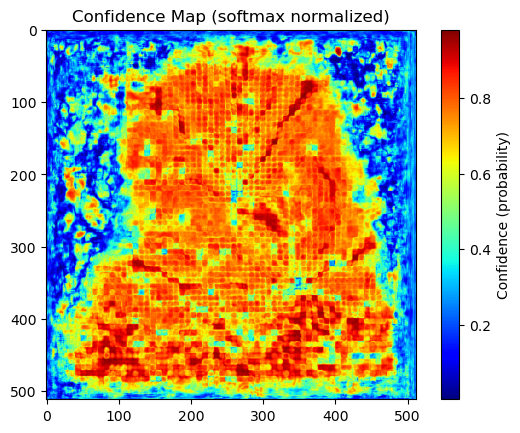

In [178]:
prob_map = torch.sigmoid(pred_dirmap[0])
max_probs, _ = torch.max(prob_map, dim=0)

plt.imshow(max_probs.cpu().detach(), cmap='jet')
plt.colorbar(label='Confidence (probability)')
plt.title('Confidence Map (softmax normalized)')
plt.show()

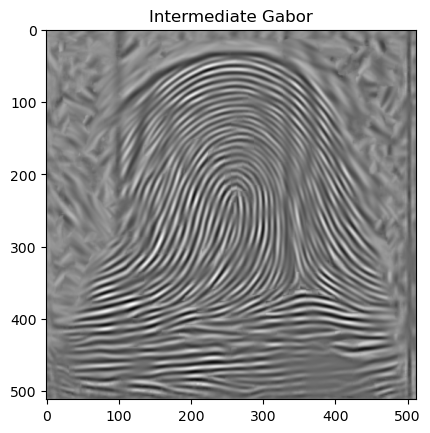

In [179]:
plt.imshow(intermediate_gabor.squeeze(1)[0].cpu().detach(), cmap='gray')
plt.title('Intermediate Gabor')
plt.show()

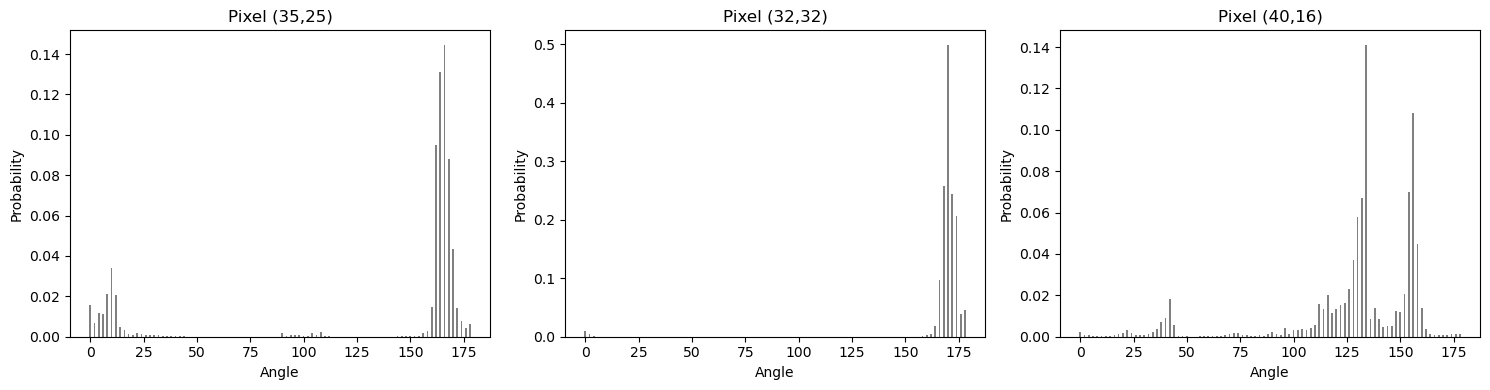

In [180]:

# Example tensor
x = prob_map
# Arbitrary pixel coordinates (list of tuples)
pixels = [(35, 25), (32, 32), (40, 16)]  # N=3 pixels

# Plot each pixel’s channel values
fig, axes = plt.subplots(1, len(pixels), figsize=(15, 4))

for ax, (i, j) in zip(axes, pixels):
    channel_values = x[:, i, j].cpu().detach().numpy()  # shape (C,)
    ax.bar([ang*2 for ang in range(len(channel_values))], channel_values, color='gray')
    ax.set_title(f'Pixel ({i},{j})')
    ax.set_xlabel('Angle')
    ax.set_ylabel('Probability')
    # ax.set_xticks([0, len(channel_values), len(channel_values)*2 - 2])


plt.tight_layout()
plt.show()
